# <center>Tropical Cyclones Wind Prediction<center>

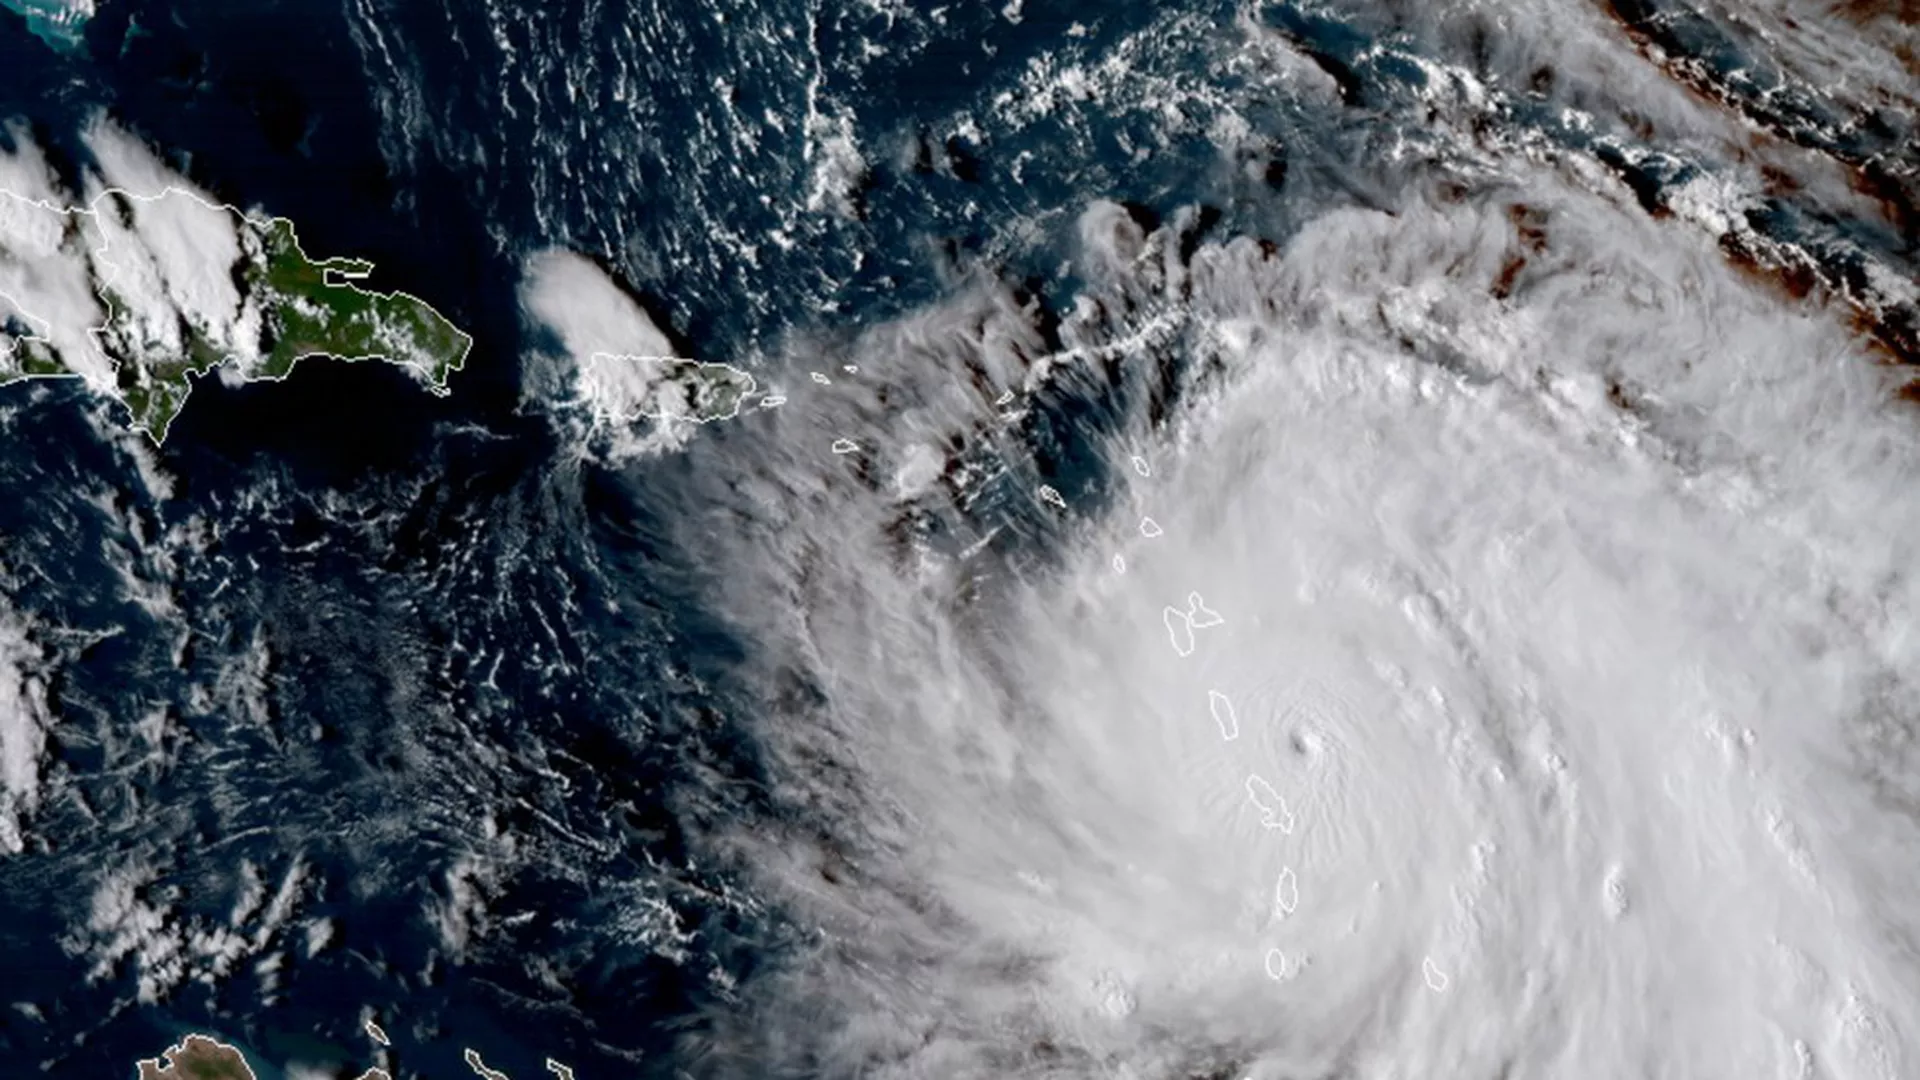

<center><b>Figure 1</b> : Ouragan Maria (Cat. 5), 2017, satellite view</center>

* *Authors : Manon ABISSEROR, Octave MESNARD & Martin DECULTIEUX, ISUP CS3*
* *Data : International Best Track Archive for ClimateStewardship (IBTrACS)* [Click here to download](https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.ALL.v04r00.nc)

### Agenda:

#### 1. [Presentation of our study](#Presentation_of_our_study)<br>
$\;\;\;\;\;\;$ a. [Importing the data](#Importing_the_data)<br>
$\;\;\;\;\;\;$ b. [Defining our scope](#Defining_our_scope)<br>
$\;\;\;\;\;\;$ c. [Cleaning the data](#Cleaning_the_data)<br>
$\;\;\;\;\;\;$ d. [Missing values from IBTrACS](#Missing_values_from_IBTrACS)<br>
$\;\;\;\;\;\;$ e. [Adding custom columns](#Adding_custom_columns)<br>
$\;\;\;\;\;\;$ f. [Final data](#Final_data)<br>


#### 2. Describing methodologies
#### 3. Visualize the results
#### 4. Interpreting our results
#### 5. Conclusion, uncertainties, limits & next steps

<a class="anchor" id="Presentation_of_our_study"></a>
## 1. Presentation of our study

The International Best Track Archive for ClimateStewardship is a dataset collected by the National Oceanic and Atmospheric Administration (NOAA). It gathers multiple informations on cyclones observed by diverse agencies across the globe. <br>

**Our goal is to predict the wind maximum speed that can occur in a certain area across a certain period of time.** By doing this, we are increasing our understanding of the catastrophic risk that can threat an insurance portfolio. This knowledge can be particularly useful for reserving purpose, pricing, arbitrage commitees,solvency requirements and others since it is the hazard component of the risk function used in Insurance industry (see below).<br>
<br>
<center>$Risk function = f(financial;vulnerability;hazard)$</center>
<br>
First, let's import and discribe the data.

<a class="anchor" id="Importing_the_data"></a>
#### a. Importing the data

We import the IBTrACS data provided by NOAA. The documentation available on NOAA website describes the 163 variables available [Click here to download the documentation](https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_v04_column_documentation.pdf)

In [139]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings
import matplotlib.image as mpimg
from scipy.stats import kde
from scipy.stats import gaussian_kde

%matplotlib inline

warnings.simplefilter('ignore')

#directories
#os.chdir("C:\\Users\octav\Downloads")
os.chdir("/Users/martindecultieux/Desktop/ISUP/Master 2/Science des données/ML Projet")

#available at this url https://www.ncdc.noaa.gov/ibtracs/index.php?name=ib-v4-access
DATA = pd.read_csv("ibtracs.ALL.list.v04r00.csv")
DATA = DATA.iloc[1:]

In [120]:
print(DATA.describe())
DATA.shape

                  SID  SEASON  NUMBER   BASIN SUBBASIN       NAME  \
count          694322  694322  694322  572161   601084     694322   
unique          13446     174     183       6        8       1811   
top     1997013S08101    1997       5      WP       MM  NOT_NAMED   
freq              352    9446    9567  232769   427699     323208   

                   ISO_TIME  NATURE       LAT       LON  ... BOM_GUST_PER  \
count                694322  694322  694322.0  694322.0  ...       694322   
unique               332053       6  288523.0  268288.0  ...           38   
top     1966-09-11 06:00:00      TS      16.0     128.0  ...                
freq                     12  488930    1047.0     236.0  ...       686443   

       REUNION_GUST REUNION_GUST_PER USA_SEAHGT  USA_SEARAD_NE USA_SEARAD_SE  \
count        694322           694322     694322         694322        694322   
unique            1                3          2            213           195   
top                         

(694322, 163)

We count {{count_obs}} observation on our data set, which seems to be sufficient to define a smaller scope of study, focusing on a certain period, and a certain area.

<a class="anchor" id="Defining_our_scope"></a>
#### b. Defining our scope

##### Considered period
We have read in the documentation provided that due to non-digital recording methods, observations before 1950 might present data quality issues.

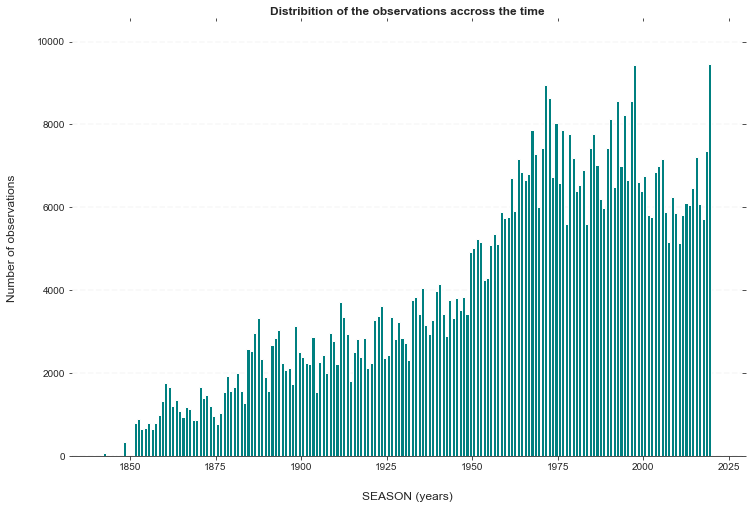

In [140]:
DATA['SEASON'] = pd.to_numeric(DATA['SEASON'])

ax = DATA.hist(column='SEASON', bins=max(DATA['SEASON'])-min(DATA['SEASON']), grid=False, figsize=(12,8), color='teal', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("Distribition of the observations accross the time",weight='bold')

    # Set x-axis label
    x.set_xlabel("SEASON (years)", labelpad=20, size=12)

    # Set y-axis label
    x.set_ylabel("Number of observations", labelpad=20, size=12)

In [141]:
print("We have ", sum(i > 1950 for i in DATA.SEASON)," observations above 1950, that is to say ", round(sum(i > 1950 for i in DATA.SEASON)/sum(i > 0 for i in DATA.SEASON)*100,2),"% of our dataset.") 

We have  459256  observations above 1950, that is to say  66.14 % of our dataset.


Since we have enough data to consider and we might face data quality issues if we keep early observations, **we decide to reduce our scope to observations collected after 1950**.

In [142]:
# filter year of completion
DATA = DATA[DATA.SEASON> 1950]

##### Considered area
After reading the documentation, we've seen that cyclones are classified by bassin and sub-bassin in our dataset. Cyclones from different bassin can't be compared since meteorological conditions, sea depth and other parameters make them very different depending on their location : not the same size, not the same velocity, etc. That's why we want to reduce the scope to one bassin.

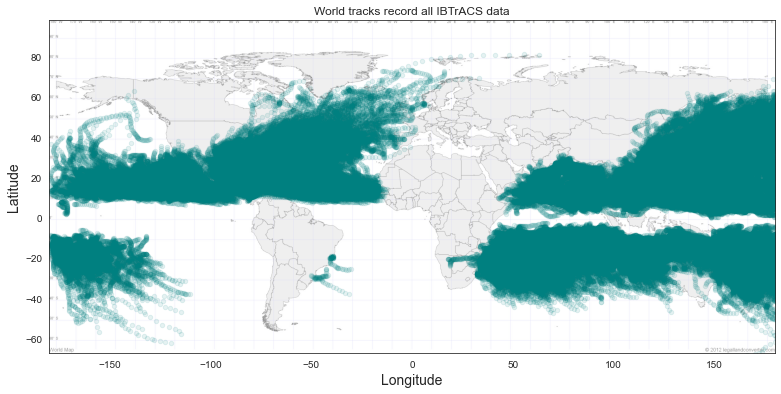

In [143]:
DATA['LON'] = pd.to_numeric(DATA['LON'])
DATA['LAT'] = pd.to_numeric(DATA['LAT'])
world_img=mpimg.imread('world.jpg')
ax = DATA.plot(kind="scatter", x="LON", y="LAT", figsize=(13,9),alpha=0.1, color='teal')
plt.imshow(world_img, extent=[-180, 180, -67, 98], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("World tracks record all IBTrACS data")
plt.show()

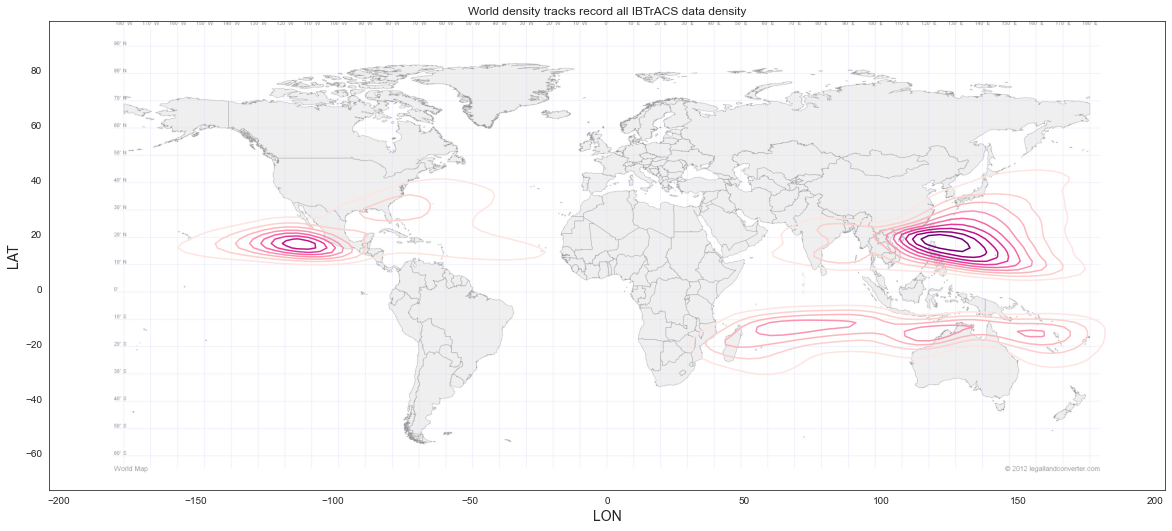

In [95]:
DATA= DATA[DATA['LON']<180]
# Basic 2D density plot
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(world_img, extent=[-180, 180, -67, 98], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("World density tracks record all IBTrACS data density")
sns.set_style("white")
sns.kdeplot(DATA.LON, DATA.LAT, cmap="RdPu")
plt.show()

We identify 3 main bassins contaning a high record density : one concentrating main part of the data located in West Pacific, a sond in North Atlantic, and a third one more difuse from West Africa to South Pacific.<br>
We have decided to keep one of those 3 bassins : **West Pacific (WP)**.

In [144]:
#Filtering on the bassin
basin = ['WP']
DATA= DATA[DATA.BASIN.isin(basin)]

Now we have filtered, we can plot the cosidered data.

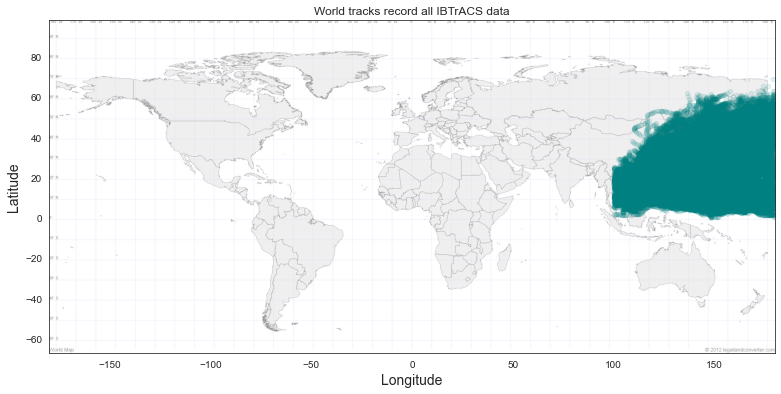

In [97]:
import matplotlib.image as mpimg
DATA['LON'] = pd.to_numeric(DATA['LON'])
DATA['LAT'] = pd.to_numeric(DATA['LAT'])
world_img=mpimg.imread('world.jpg')
ax = DATA.plot(kind="scatter", x="LON", y="LAT", figsize=(13,9),alpha=0.1, color='teal')
plt.imshow(world_img, extent=[-180, 180, -67, 98], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("World tracks record all IBTrACS data")
plt.show()

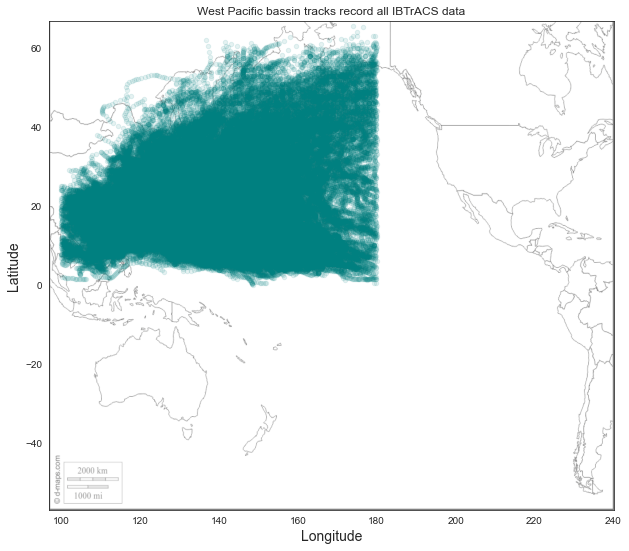

We have  164695  observations in our dataset.


In [98]:
import matplotlib.image as mpimg
DATA['LON'] = pd.to_numeric(DATA['LON'])
DATA['LAT'] = pd.to_numeric(DATA['LAT'])
WP_img=mpimg.imread('WP.gif')
ax = DATA.plot(kind="scatter", x="LON", y="LAT", figsize=(13,9),alpha=0.1, color='teal')
plt.imshow(WP_img, extent=[97, 240, -57, 67], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("West Pacific bassin tracks record all IBTrACS data")
plt.show()
print("We have ",sum(i > 0 for i in DATA.SEASON)," observations in our dataset.") 

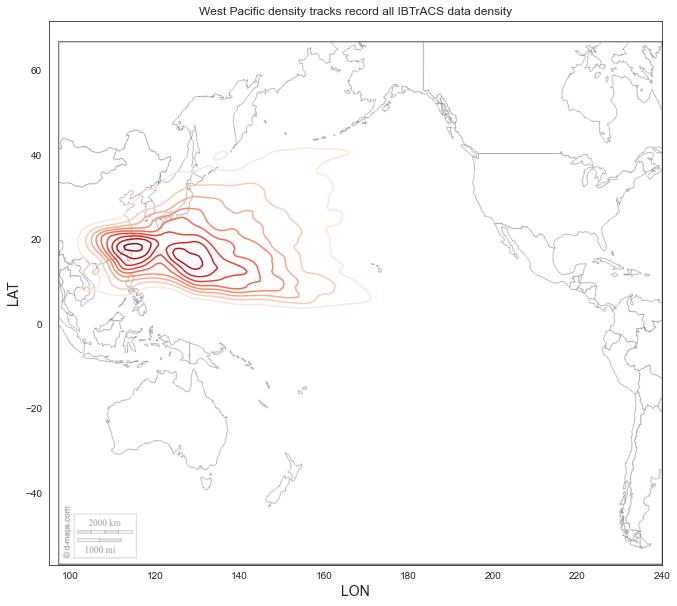

In [99]:
# Basic 2D density plot
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(WP_img, extent=[97, 240, -57, 67], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title("West Pacific density tracks record all IBTrACS data density")
sns.set_style("white")
sns.kdeplot(DATA.LON, DATA.LAT, cmap="Reds", shade=False)
plt.show()

<a class="anchor" id="Cleaning_the_data"></a>
#### c. Cleaning the data
We will now go on general cleaning of the data.

Text(0.5, 1.0, 'West Pacific bassin nature record all IBTrACS data from 1950')

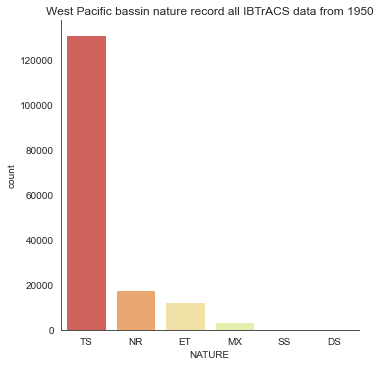

In [100]:
sns.catplot(x="NATURE", kind="count", palette="Spectral", data=DATA)
plt.title("West Pacific bassin nature record all IBTrACS data from 1950")

Text(0.5, 1.0, 'West Pacific bassin Track-type category record all IBTrACS data from 1950')

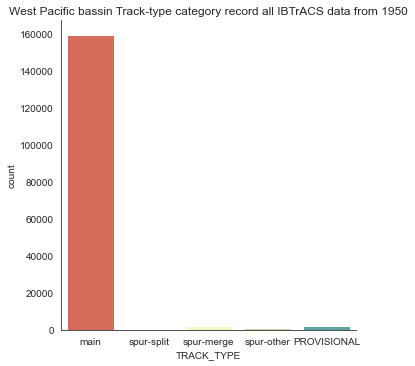

In [101]:
sns.catplot(x="TRACK_TYPE", kind="count", palette="Spectral", data=DATA)
plt.title("West Pacific bassin Track-type category record all IBTrACS data from 1950")

In [145]:
count_series = DATA.groupby(['SID']).size()
RES = count_series.to_frame()
subset_RES = RES[RES[0] > 2]
print("The weight of cyclones with less than 3 observations : duration of less than 12 hours is ",round(sum(subset_RES[0])/sum(RES[0]),2)," %")

The weight of cyclones with less than 3 observations : duration of less than 12 hours is  1.0  %


The weight of cyclones with less than 3 observations : duration of less than 12 hours is  `round(sum(subset_RES[0])/sum(RES[0]),2) ` %

In [146]:
#Filtering on Tropical & extra tropical nature cyclones and on main tracks following documentation explanations
nature = ['TS', 'ET']
DATA= DATA[DATA.NATURE.isin(nature)]
DATA= DATA[DATA['TRACK_TYPE'] == "main"]

#filter small tracks (cyclones with less than 3 observations : duration of less than 12 hours)
DATA = pd.merge(DATA, RES, on = "SID" )
DATA.rename( columns={0 :'LENGTH'}, inplace=True )
DATA = DATA[DATA.LENGTH > 2]

#KEEP ONLY FORMAT EVERY 3hours (reported every 6 hours st eather 3am 9am 3pm 9pm, or 12am 06am 12pm 6pm)
import re
DATA['3H'] = [re.search("00:00:00|03:00:00|06:00:00|09:00:00|12:00:00|15:00:00|18:00:00|21:00:00",a) is not None for a in DATA.ISO_TIME]
DATA = DATA[DATA['3H'] == True]

#pressure and wind completion (transform into numeric)
DATA['WIND_1MIN_KNT'] = pd.to_numeric(DATA['USA_WIND'],errors='coerce')
DATA['Pressure'] = pd.to_numeric(DATA['USA_PRES'],errors='coerce')
DATA['Rmw'] = pd.to_numeric(DATA['USA_RMW'],errors='coerce')
DATA['ROCI'] = pd.to_numeric(DATA['USA_ROCI'],errors='coerce')
DATA['POCI'] = pd.to_numeric(DATA['USA_POCI'],errors='coerce')

print(DATA.head())

             SID  SEASON NUMBER BASIN SUBBASIN       NAME  \
0  1951050N20139    1951     15    WP       MM  NOT_NAMED   
1  1951050N20139    1951     15    WP       MM  NOT_NAMED   
2  1951050N20139    1951     15    WP       MM  NOT_NAMED   
3  1951050N20139    1951     15    WP       MM  NOT_NAMED   
4  1951050N20139    1951     15    WP       MM  NOT_NAMED   

              ISO_TIME NATURE      LAT      LON  ... USA_SEARAD_NW  \
0  1951-02-19 06:00:00     TS  20.0000  138.500  ...                 
1  1951-02-19 09:00:00     TS  19.6732  138.152  ...                 
2  1951-02-19 12:00:00     TS  20.0000  138.500  ...                 
3  1951-02-19 15:00:00     TS  21.3532  139.999  ...                 
4  1951-02-19 18:00:00     TS  23.0000  142.100  ...                 

  STORM_SPEED STORM_DIR LENGTH    3H WIND_1MIN_KNT Pressure Rmw ROCI POCI  
0           9       225     19  True           NaN      NaN NaN  NaN  NaN  
1           0         0     19  True           NaN      NaN 

The goal here is to construct a unique column for each variable collected separately across the agencies. For instance we will gather wind max speed in a unique column composed of data from USA agency, Tokyo agency, Hong Kong agency, and other agencies that have observed the cyclones of our scope.

In [147]:
#Gathering max speed wind collected every 6 hours (coefficients due to 2 different max speed wind calculation across the agencies, some calculate max of 10 minutes mean wind (max of 36 means) wheareas others calculate max of 1 minute mean wind (max of 360 means))
missing_wind = DATA.loc[pd.isna(DATA["WIND_1MIN_KNT"]), :].index
DATA.WIND_1MIN_KNT[missing_wind] = pd.to_numeric(DATA.TOKYO_WIND[missing_wind],errors='coerce')*1.05

missing_wind = DATA.loc[pd.isna(DATA["WIND_1MIN_KNT"]), :].index
DATA.WIND_1MIN_KNT[missing_wind] = pd.to_numeric(DATA.CMA_WIND[missing_wind],errors='coerce')*1

missing_wind = DATA.loc[pd.isna(DATA["WIND_1MIN_KNT"]), :].index
DATA.WIND_1MIN_KNT[missing_wind] = pd.to_numeric(DATA.HKO_WIND[missing_wind],errors='coerce')*1.05

missing_wind = DATA.loc[pd.isna(DATA["WIND_1MIN_KNT"]), :].index
DATA.WIND_1MIN_KNT[missing_wind] = pd.to_numeric(DATA.TD9636_WIND[missing_wind],errors='coerce')*1

missing_wind = DATA.loc[pd.isna(DATA["WIND_1MIN_KNT"]), :].index
DATA.WIND_1MIN_KNT[missing_wind] = pd.to_numeric(DATA.TD9635_WIND[missing_wind],errors='coerce')*1

missing_wind = DATA.loc[pd.isna(DATA["WIND_1MIN_KNT"]), :].index
DATA.WIND_1MIN_KNT[missing_wind] = pd.to_numeric(DATA.DS824_WIND[missing_wind],errors='coerce')*1

missing_wind = DATA.loc[pd.isna(DATA["WIND_1MIN_KNT"]), :].index
DATA.WIND_1MIN_KNT[missing_wind] = pd.to_numeric(DATA.MLC_WIND[missing_wind],errors='coerce')*1



#Gathering pressure collected every 6 hours
missing_pressure = DATA.loc[pd.isna(DATA["Pressure"]), :].index
DATA.Pressure[missing_pressure]= pd.to_numeric(DATA.TOKYO_PRES[missing_pressure],errors='coerce')

missing_pressure = DATA.loc[pd.isna(DATA["Pressure"]), :].index
DATA.Pressure[missing_pressure] = pd.to_numeric(DATA.CMA_PRES[missing_pressure],errors='coerce')

missing_pressure = DATA.loc[pd.isna(DATA["Pressure"]), :].index
DATA.Pressure[missing_pressure] = pd.to_numeric(DATA.HKO_PRES[missing_pressure],errors='coerce')

missing_pressure = DATA.loc[pd.isna(DATA["Pressure"]), :].index
DATA.Pressure[missing_pressure] = pd.to_numeric(DATA.TD9636_PRES[missing_pressure],errors='coerce')

missing_pressure = DATA.loc[pd.isna(DATA["Pressure"]), :].index
DATA.Pressure[missing_pressure] = pd.to_numeric(DATA.TD9635_PRES[missing_pressure],errors='coerce')

missing_pressure = DATA.loc[pd.isna(DATA["Pressure"]), :].index
DATA.Pressure[missing_pressure] = pd.to_numeric(DATA.DS824_PRES[missing_pressure],errors='coerce')

missing_pressure = DATA.loc[pd.isna(DATA["Pressure"]), :].index
DATA.Pressure[missing_pressure] = pd.to_numeric(DATA.MLC_PRES[missing_pressure],errors='coerce')


#Gathering wind radius, radius of last isobar, pressure at last isobar

#rayon de l'oeil, BOM et REUNION deux agences sur lesquelles on a des données
missing_rmw = DATA.loc[pd.isna(DATA["Rmw"]), :].index
DATA.Rmw[missing_rmw] = pd.to_numeric(DATA.BOM_RMW[missing_rmw],errors='coerce')

missing_rmw = DATA.loc[pd.isna(DATA["Rmw"]), :].index
DATA.Rmw[missing_rmw] = pd.to_numeric(DATA.REUNION_RMW[missing_rmw],errors='coerce')

#a supprimer peut etre :

#radius of last isobar
missing_roci = DATA.loc[pd.isna(DATA["ROCI"]), :].index
DATA.ROCI[missing_roci] = pd.to_numeric(DATA.BOM_ROCI[missing_roci],errors='coerce')

missing_roci = DATA.loc[pd.isna(DATA["ROCI"]), :].index
DATA.ROCI[missing_roci] = pd.to_numeric(DATA.TD9635_ROCI[missing_roci],errors='coerce')

#pressure at last isobar
missing_poci = DATA.loc[pd.isna(DATA["POCI"]), :].index
DATA.POCI[missing_poci] = pd.to_numeric(DATA.BOM_POCI[missing_poci],errors='coerce')

print(DATA.describe())
DATA.shape

              SEASON            LAT            LON         LENGTH  \
count  140883.000000  140883.000000  140883.000000  140883.000000   
mean     1982.728697      21.088622     135.055348      84.733233   
std        19.031414      10.097486      17.052995      34.405916   
min      1951.000000       0.490004     100.000000       3.000000   
25%      1967.000000      13.956350     122.123000      59.000000   
50%      1981.000000      19.083900     133.351000      83.000000   
75%      1999.000000      25.917350     146.500000     107.000000   
max      2018.000000      69.000000     179.998000     227.000000   

       WIND_1MIN_KNT       Pressure           Rmw          ROCI          POCI  
count  123089.000000  139268.000000  21814.000000  55849.000000  21844.000000  
mean       52.070220     986.609077     31.203126    228.812763   1004.590872  
std        31.043452      22.192708     15.837680    114.891672      4.320720  
min       -99.000000     870.000000      5.000000    -99.0

(140883, 170)

We will now drop non essential columns. We drop "DIST2LAND" on purpose since we found more accurate data to fill this variable in part e. [Adding custom columns](#Adding_custom_columns)

In [148]:
#keeping only the important columns
ID = DATA['SID'] 
Year = DATA['SEASON']
Name= DATA['NAME']
ISO_time = DATA['ISO_TIME']
Nature = DATA['NATURE']
Latitude = DATA['LAT']
Longitude= DATA['LON']
Wind_kts= DATA['WIND_1MIN_KNT']
Rmw= DATA['Rmw']
Roci= DATA['ROCI']
Poci= DATA['POCI']
Landfall= DATA['LANDFALL']
ForwardSpeed= pd.to_numeric(DATA['STORM_SPEED'],errors='coerce')*1.852
Bearing= DATA['STORM_DIR']
LON = round(Longitude,1)
LAT = round(Latitude,1)
    
#bearing = "cap" & forward speed = "vitesse de deplacement"

# and merge them by using zip().  
list_of_tuples = list(zip(ID, Year, Name, ISO_time, Nature, Latitude, Longitude, Wind_kts,
                         Rmw, Roci, Poci, Landfall, ForwardSpeed, Bearing, LON, LAT))


DATA = pd.DataFrame(list_of_tuples, columns = ['ID', 'Year', 'Name','ISO_time', 'Nature', 'Latitude', 'Longitude',
                                                      'Wind_kts', 'Rmw',
                                                      'Roci', 'Poci', 'Landfall', 'ForwardSpeed', 'Bearing', 'LON', 'LAT'])  

print(DATA)

                   ID  Year       Name             ISO_time Nature  Latitude  \
0       1951050N20139  1951  NOT_NAMED  1951-02-19 06:00:00     TS  20.00000   
1       1951050N20139  1951  NOT_NAMED  1951-02-19 09:00:00     TS  19.67320   
2       1951050N20139  1951  NOT_NAMED  1951-02-19 12:00:00     TS  20.00000   
3       1951050N20139  1951  NOT_NAMED  1951-02-19 15:00:00     TS  21.35320   
4       1951050N20139  1951  NOT_NAMED  1951-02-19 18:00:00     TS  23.00000   
...               ...   ...        ...                  ...    ...       ...   
140878  2018365N08115  2018      PABUK  2019-01-03 21:00:00     TS   7.51502   
140879  2018365N08115  2018      PABUK  2019-01-04 00:00:00     TS   7.90000   
140880  2018365N08115  2018      PABUK  2019-01-04 03:00:00     TS   8.15244   
140881  2018365N08115  2018      PABUK  2019-01-04 06:00:00     TS   8.30000   
140882  2018365N08115  2018      PABUK  2019-01-04 09:00:00     TS   8.36488   

        Longitude  Wind_kts   Rmw   Roc

<a class="anchor" id="Missing_values_from_IBTrACS"></a>
#### d. Missing values from IBTrACS

In [149]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


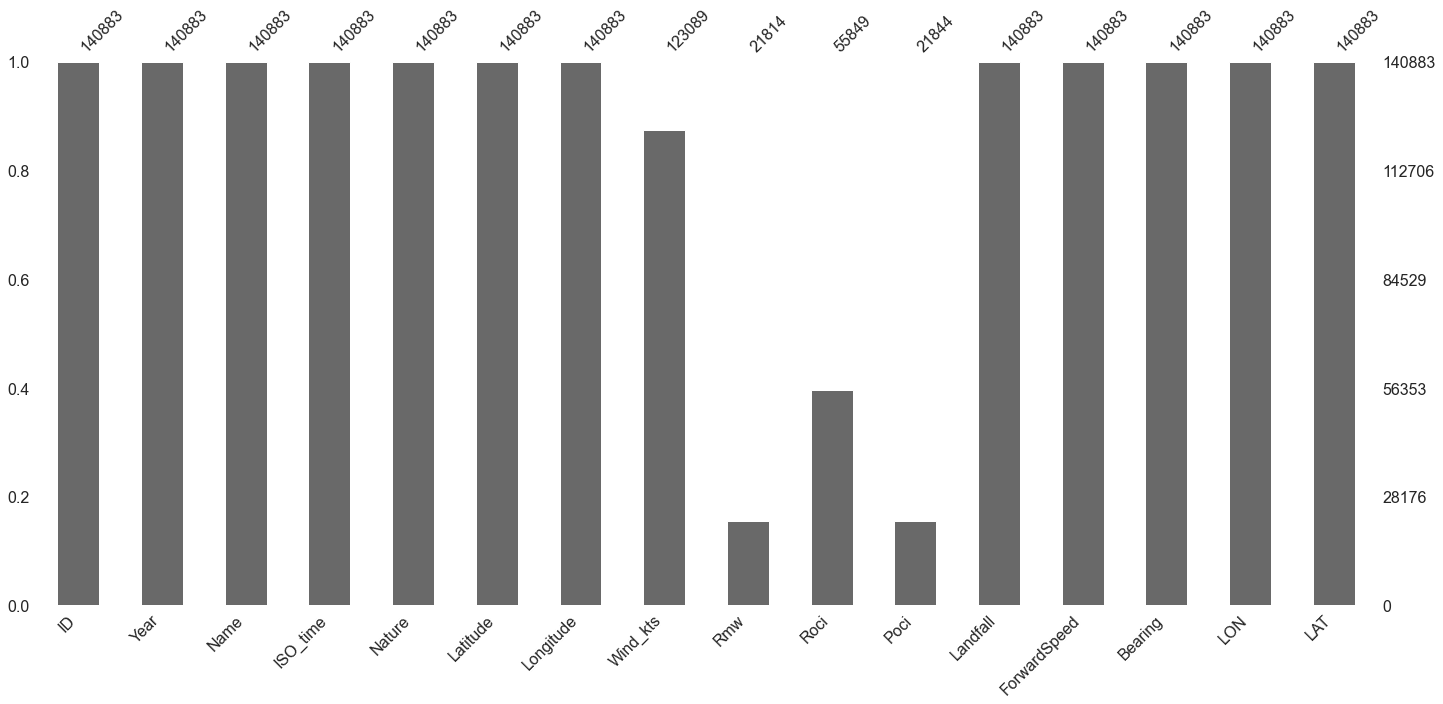

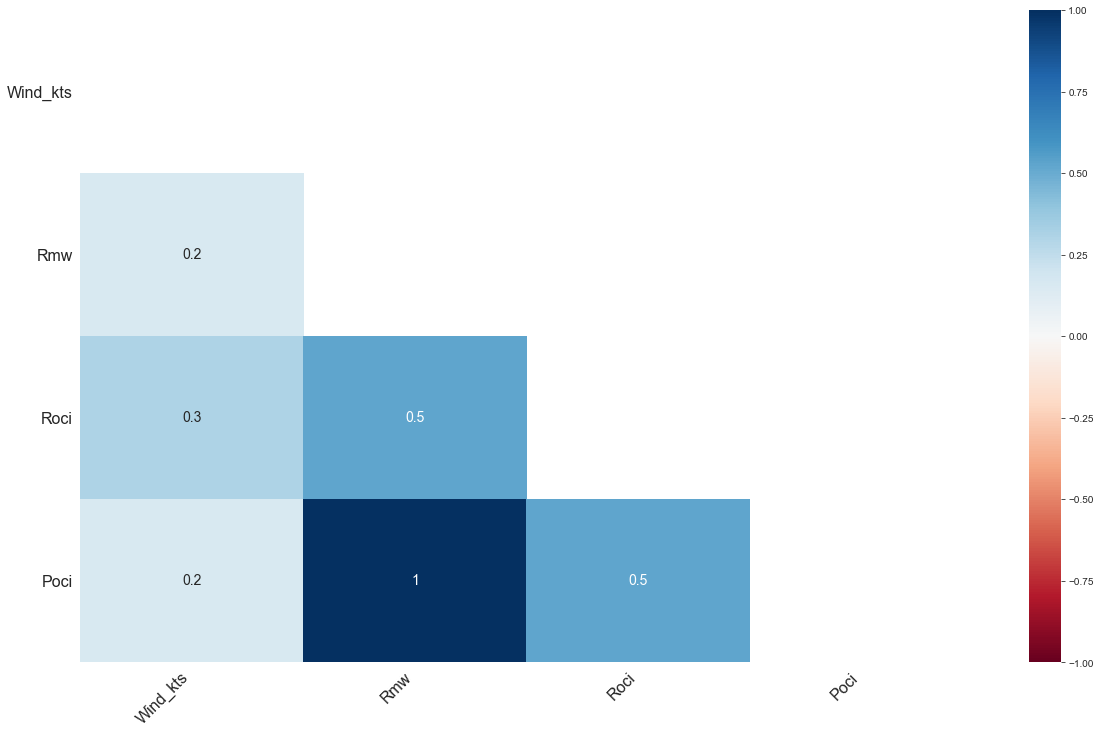

In [150]:
# Program to visualize missing values in dataset 

# Importing the library
import missingno as msno 

# Visualize the number of missing 
# values as a bar chart 
msno.bar(DATA) 
msno.heatmap(DATA)

* We will first handle the Wind_kts variable, which has less than 20% missing values. We can reasonably think that filling the missing values of that variable by linear interpolation can be a good approximation, in the limit of 5 consecutive missing values, otherwise we will use the mean.

* Then we will leave the Rmw variable (radius of the cyclone) since we have around 85% of missing values, even if its value can help to understand what type of cyclone it is. Same treatment for Roci and Poci.

In [151]:
DATA_full= DATA.sort_values(['ID', 'ISO_time'])
DATA_full.Wind_kts=DATA_full.Wind_kts.interpolate(limit=5)
DATA_full['Wind_kts'].fillna((DATA_full['Wind_kts'].mean()), inplace=True)
DATA_full=DATA_full.drop(columns=['Rmw', 'Roci','Poci'])

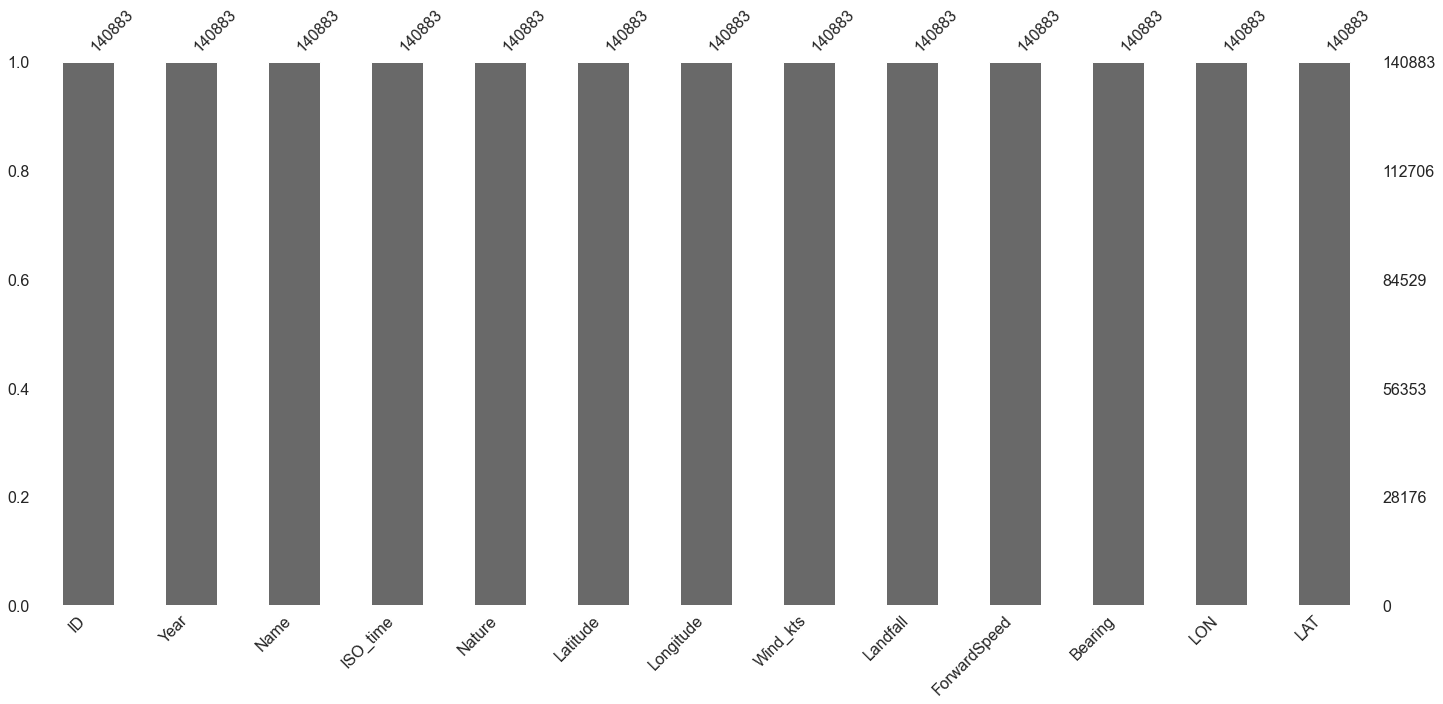

In [152]:
msno.bar(DATA_full) 

<a class="anchor" id="Adding_custom_columns"></a>
#### e. Adding custom columns

##### Saffir-Simpson category
We want to add the Saffir-Simpson category to each cyclone, considering its max wind speed. The scale is given below and will be applied to our observation in a new variable called $"SS$_$category"$. We also add a column called $"SS$_$max"$ that represents the highest category reached by the cyclone during its life.
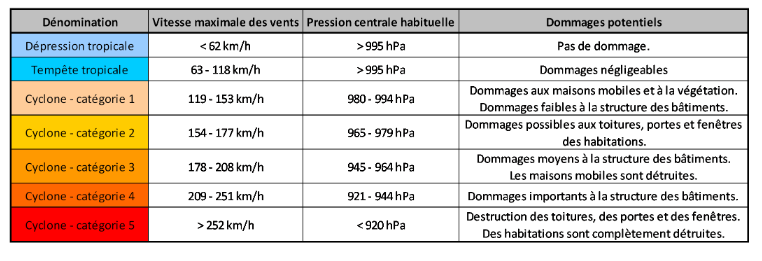
<center><b>Figure 2</b> : Saffir Simpson categories </center>

In [153]:
#saffir simpson category

#conversion from knots to km/h

DATA=DATA_full
DATA['WIND_1MIN_KMH'] = DATA['Wind_kts']*1.852


conditions = [
    (DATA["WIND_1MIN_KMH"].lt(119)),
    (DATA["WIND_1MIN_KMH"].ge(119) & DATA["WIND_1MIN_KMH"].lt(153)),
    (DATA["WIND_1MIN_KMH"].ge(153) & DATA["WIND_1MIN_KMH"].lt(177)),
    (DATA["WIND_1MIN_KMH"].ge(177) & DATA["WIND_1MIN_KMH"].lt(208)),
    (DATA["WIND_1MIN_KMH"].ge(208) & DATA["WIND_1MIN_KMH"].lt(251)),
    (DATA["WIND_1MIN_KMH"].ge(251))]
#where category 0 corresponds to "Dépression tropicale" or "Tempête tropicale", category 1 to 5 corresponds to Saffir Simpson categories
choices = [0,1,2,3,4,5]

DATA["SS_Category"] = np.select(conditions, choices)

ss_max = DATA.groupby('ID')['SS_Category'].max()
ss_max = ss_max.to_frame()

DATA = pd.merge(DATA, ss_max, on = "ID" )
DATA.rename( columns={'SS_Category_y' :'SS_MAX'}, inplace=True )
DATA.rename( columns={'SS_Category_x' :'SS_Category'}, inplace=True )
print(DATA.describe())
DATA.shape

                Year       Latitude      Longitude       Wind_kts  \
count  140883.000000  140883.000000  140883.000000  140883.000000   
mean     1982.728697      21.088622     135.055348      50.951913   
std        19.031414      10.097486      17.052995      29.483802   
min      1951.000000       0.490004     100.000000     -99.000000   
25%      1967.000000      13.956350     122.123000      29.000000   
50%      1981.000000      19.083900     133.351000      45.000000   
75%      1999.000000      25.917350     146.500000      65.000000   
max      2018.000000      69.000000     179.998000     185.000000   

        ForwardSpeed            LON            LAT  WIND_1MIN_KMH  \
count  140883.000000  140883.000000  140883.000000  140883.000000   
mean       20.699642     135.055343      21.088488      94.362943   
std        13.326375      17.053018      10.097553      54.604002   
min         0.000000     100.000000       0.500000    -183.348000   
25%        12.964000     122.1000

(140883, 16)

Text(0.5, 1.0, 'West Pacific bassin Saffir Simpson category record all IBTrACS data from 1950')

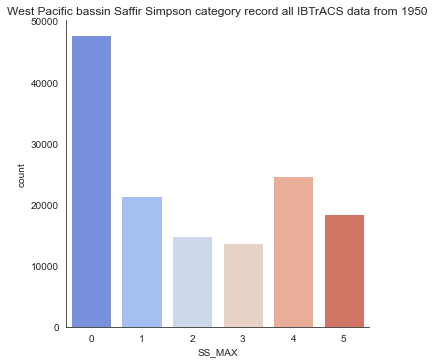

In [154]:
sns.catplot(x="SS_MAX", kind="count", palette="coolwarm", data=DATA)
plt.title("West Pacific bassin Saffir Simpson category record all IBTrACS data from 1950")

###### Distance to coast
Adding a variable Distance to coast which gives more information than DIST2LAND.
* Distance to coast is positive when LAT and LON are in the sea
* Distance to coast is negative when LAT and LON are in the lands
* Distance to coast is collected by a unique agency (NOAA) and helps to increase our data quality. It can be downloaded [here.](https://catalog.data.gov/dataset/distance-to-nearest-coastline-0-04-degree-grid?fbclid=IwAR0973SsbeSuJwQuQrzb7y2ioWRjlSviMJzslyXFYFtRqVEEko_Xnq3m5tw)


In [155]:
DIST2COAST = pd.read_csv("dist2coast.txt", sep="\t", header=None)
print(DIST2COAST.shape)

(40500000, 3)


In [156]:
DIST2COAST.columns = ['LON','LAT','DIST']


DIST2COAST.LON = round(DIST2COAST.LON,1)
DIST2COAST.LAT = round(DIST2COAST.LAT,1)


DIST2COAST = DIST2COAST.drop_duplicates(subset=['LAT', 'LON'])
print(DIST2COAST.shape)

(6485401, 3)


In [157]:
FINAL_DATA = pd.merge(DATA, DIST2COAST,  on=["LON", "LAT"])
FINAL_DATA = FINAL_DATA.sort_values(['ID', 'ISO_time'])
print(FINAL_DATA)

                   ID  Year       Name             ISO_time Nature  Latitude  \
0       1951050N20139  1951  NOT_NAMED  1951-02-19 06:00:00     TS  20.00000   
3       1951050N20139  1951  NOT_NAMED  1951-02-19 09:00:00     TS  19.67320   
1       1951050N20139  1951  NOT_NAMED  1951-02-19 12:00:00     TS  20.00000   
5       1951050N20139  1951  NOT_NAMED  1951-02-19 15:00:00     TS  21.35320   
7       1951050N20139  1951  NOT_NAMED  1951-02-19 18:00:00     TS  23.00000   
...               ...   ...        ...                  ...    ...       ...   
140878  2018365N08115  2018      PABUK  2019-01-03 21:00:00     TS   7.51502   
140879  2018365N08115  2018      PABUK  2019-01-04 00:00:00     TS   7.90000   
140880  2018365N08115  2018      PABUK  2019-01-04 03:00:00     TS   8.15244   
140881  2018365N08115  2018      PABUK  2019-01-04 06:00:00     TS   8.30000   
140882  2018365N08115  2018      PABUK  2019-01-04 09:00:00     TS   8.36488   

        Longitude   Wind_kts Landfall  

<a class="anchor" id="Final_data"></a>
#### f. Final data

In [158]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0-py2.py3-none-any.whl size=258952 sha256=89e6512295595de7449bee21ba33525972cd382c83ffe966804dbf4601d4acd0
  Stored in directory: /private/var/folders/m4/h2v12t1j0yvbmhfs6xjdf9p40000gn/T/pip-ephem-wheel-cache-7h0v_t5f/wheels/64/b6/85/dfc808b23666a5910371784e349d28818006ff63ed9cfeca59
Successfully built pandas-profiling
Note: you may need to restart the kernel to use updated packages.


In [159]:
from pandas_profiling import ProfileReport
profile = ProfileReport(FINAL_DATA)
profile.to_file(output_file='rapport.html')
profile.to_widgets()

profile.to_file("your_report.html")

In [160]:
FINAL_DATA.to_csv(r'FINALTRACK.csv', index = False)